### Here let's solve Lorenz 63 and see at what point we start getting chaotic behavior

In [1]:
# imports and config
import jax
import jax.numpy as jnp
import diffrax
import matplotlib.pyplot as plt

# Enable 64-bit floats in JAX (do this before creating JAX arrays / tracing)
jax.config.update("jax_enable_x64", True)

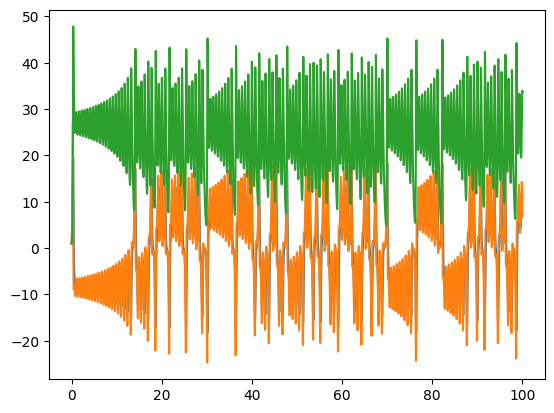

In [2]:
def lorenz_rhs(t, y, args):
    sigma, rho, beta = args
    x,y_,z = y
    return jnp.array([sigma*(y_-x), x*(rho-z)-y_, x*y_-beta*z])

solver = diffrax.Tsit5()
term = diffrax.ODETerm(lorenz_rhs)
saveat = diffrax.SaveAt(ts=jnp.linspace(0,100,20001))
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)
sol = diffrax.diffeqsolve(term, 
                        solver, 
                        t0=0.0, 
                        t1=100.0, 
                        dt0=0.01,
                        y0=jnp.array([1.,1.,1.]), 
                        args=(10.,28.,8/3), 
                        saveat=saveat,
                        max_steps=200000
                        )

plt.plot(sol.ts, sol.ys)

In [3]:
def lorenz_rhs(t, y, args):
    sigma, rho, beta = args
    x, y_, z = y
    return jnp.array([sigma * (y_ - x),
                      x * (rho - z) - y_,
                      x * y_ - beta * z], dtype=jnp.float64)

# Use float64 everywhere
solver = diffrax.Tsit5()
term = diffrax.ODETerm(lorenz_rhs)
saveat = diffrax.SaveAt(ts=jnp.linspace(0.0, 100.0, 20001, dtype=jnp.float64))
stepsize_controller = diffrax.PIDController(rtol=1e-12, atol=1e-12)
higher_def_sol = diffrax.diffeqsolve(
    term,
    solver,
    t0=jnp.float64(0.0),
    t1=jnp.float64(100.0),
    dt0=jnp.float64(0.01),
    y0=jnp.array([1.0, 1.0, 1.0], dtype=jnp.float64),
    args=(jnp.float64(10.0), jnp.float64(28.0), jnp.float64(8.0 / 3.0)),
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=200000,
)

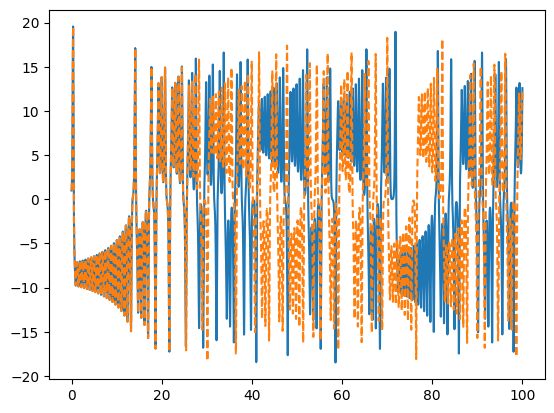

In [4]:
plt.plot(higher_def_sol.ts, higher_def_sol.ys[:, 0])
plt.plot(sol.ts, sol.ys[:, 0], linestyle='dashed')

In [5]:
### Show the l2 error between the two solutions
# We can see here that the solutions diverge after some time, as expected for a chaotic system
# And we see that the error becomes O(1) after some time as the systems diverge with comparable scale to the states
# This is consistent with the Shadow lemma because even the 32 bit solution is a "true" solution to a slightly perturbed initial condition

l2_error = jnp.linalg.norm(higher_def_sol.ys - sol.ys, axis=1)

l2_error.shape

(20001,)

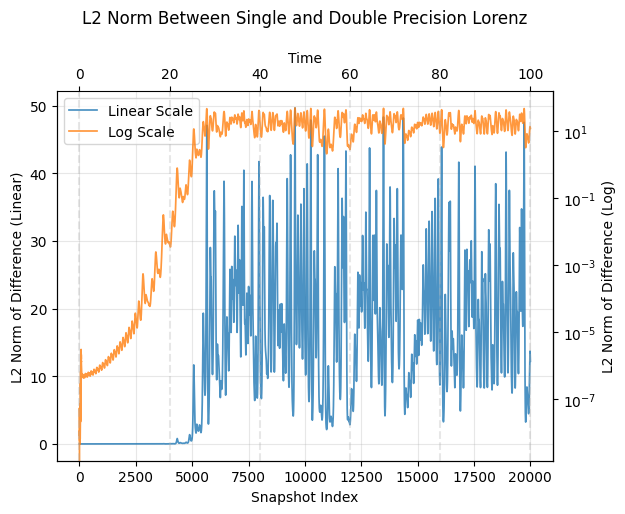

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
time_indices = jnp.arange(len(l2_error))

# Use the actual time values from the solution instead of fixed dt
actual_time = higher_def_sol.ts  # or sol.ts, they should be the same

# Plot on primary (left) axis - linear scale
line1 = ax.plot(time_indices, l2_error, lw=1.25, color='tab:blue', label='Linear Scale', alpha=0.8)
ax.set_ylabel('L2 Norm of Difference (Linear)')
ax.set_xlabel('Snapshot Index')
ax.set_title('L2 Norm Between Single and Double Precision Lorenz', pad=20)
ax.grid(alpha=0.3)
ax.tick_params(axis='y')

# Create secondary (right) y-axis - log scale
ax2 = ax.twinx()
line2 = ax2.plot(time_indices, l2_error, lw=1.25, color='tab:orange', alpha=0.8, label='Log Scale')
ax2.set_yscale('log')
ax2.set_ylabel('L2 Norm of Difference (Log)')
ax2.tick_params(axis='y')

# Create secondary (top) x-axis for actual time
ax3 = ax.twiny()
# Plot invisible line to establish the axis relationship
ax3.plot(actual_time, l2_error, alpha=0)  # Invisible plot to set limits
ax3.set_xlabel('Time')
ax3.xaxis.set_label_position('top')
ax3.xaxis.tick_top()
ax3.grid(alpha=0.3, linestyle='--', lw=1.5)

# Remove top spine for the primary axes
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
# Keep the top spine for ax3 as it shows the secondary x-axis
ax3.spines['bottom'].set_visible(False)

# Optional: Remove left spine as in original
ax.spines['left'].set_visible(False)

# Combine legends from both y-axes
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left')

# Save figure
fig.savefig('single_vs_double_lorenz.png', dpi=300, bbox_inches='tight')

### DMD Experiments

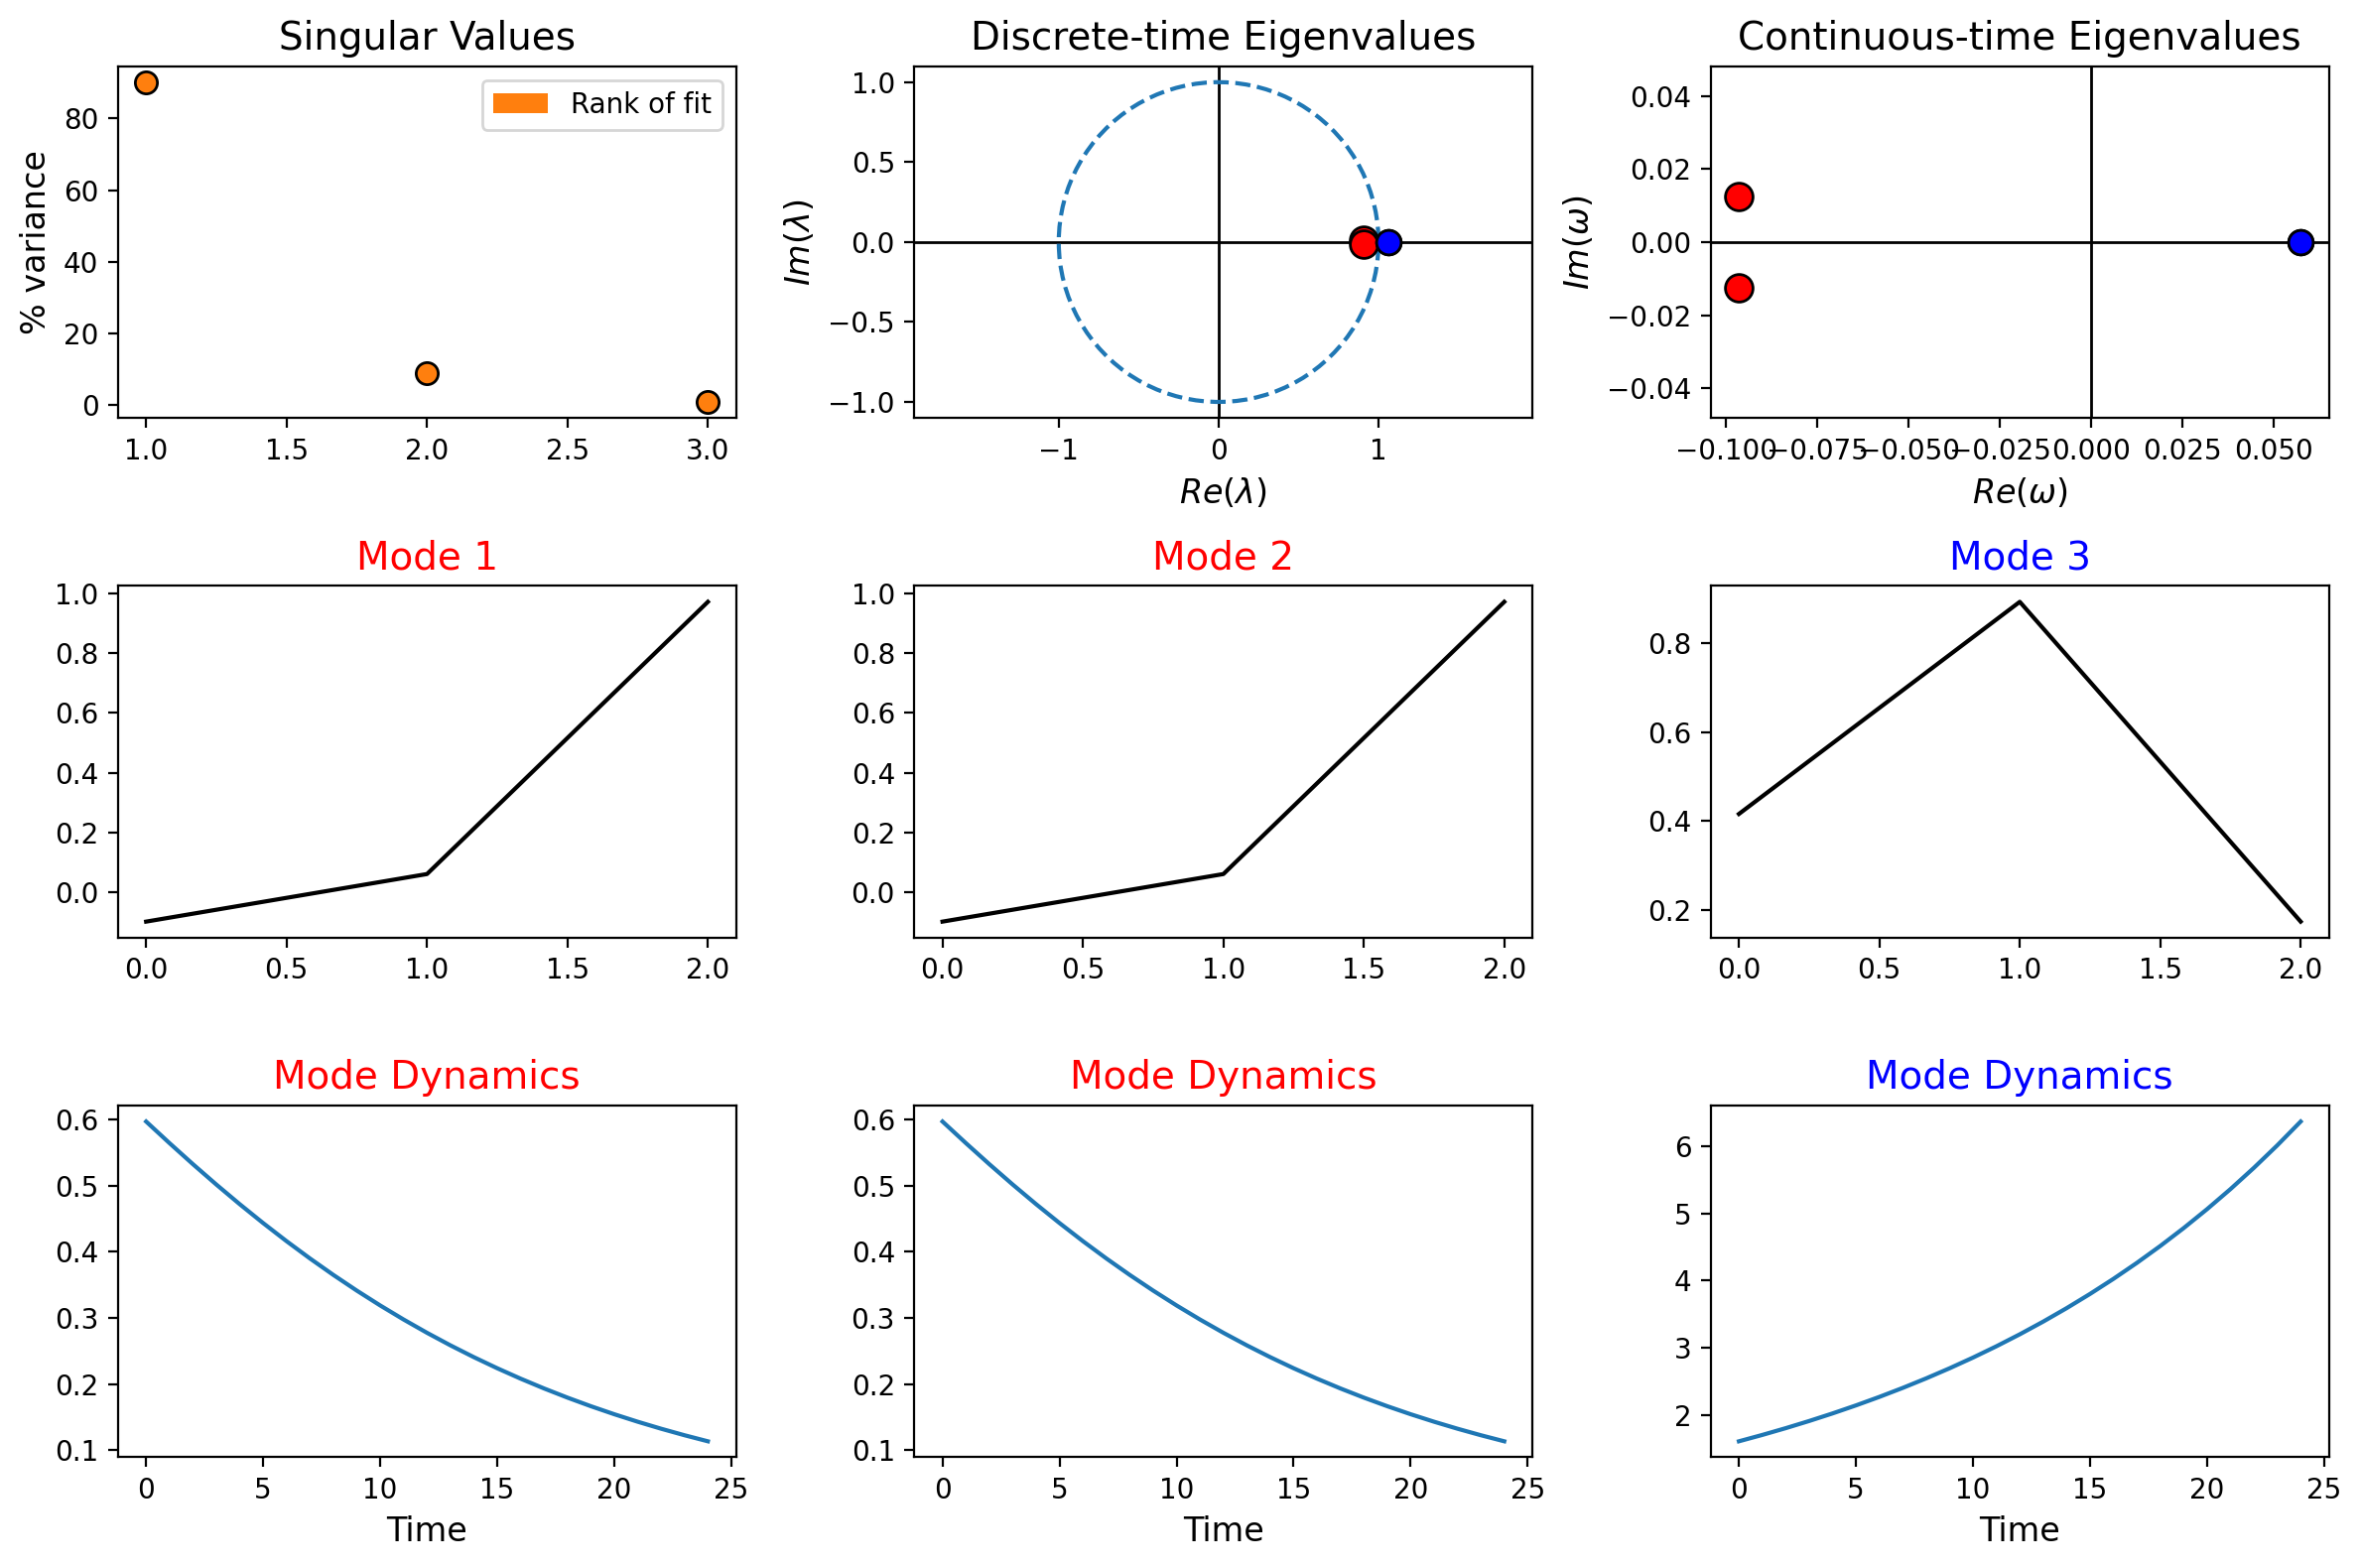

In [32]:
from pydmd import DMD
from pydmd.plotter import plot_summary

training_snapshots = sol.ys.T[:, :25]
training_time_domain = sol.ts[:25]

dmd = DMD(svd_rank=20)

dmd.fit(training_snapshots)

plot_summary(dmd)

In [33]:
dmd_prediction = dmd.predict(sol.ys.T)


DMD prediction shape: (3, 20001)
Original solution shape: (20001, 3)
DMD prediction range: [-26.399-0.000j, 45.480-0.000j]
Original solution range: [-24.672, 47.834]


/home/anthonypoole/miniconda3/envs/IEEE/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/anthonypoole/miniconda3/envs/IEEE/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


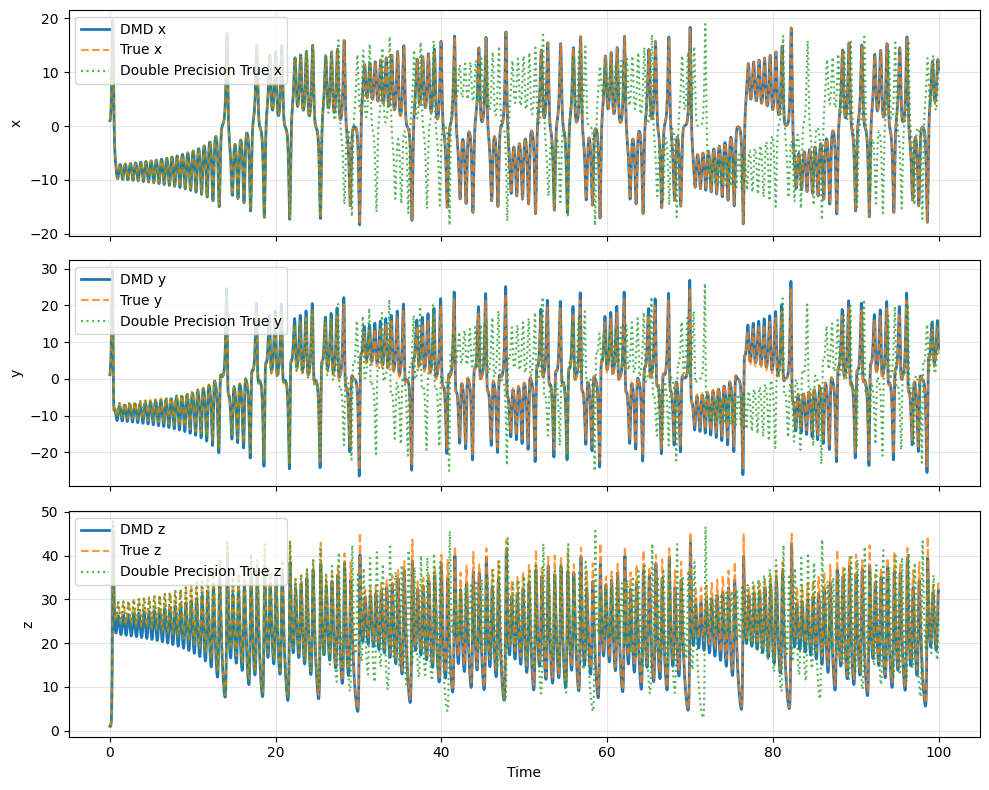

In [35]:
fig, axs = plt.subplots(3,1, figsize=(10, 8), sharex=True)

# Debug: Check shapes and data
print(f"DMD prediction shape: {dmd_prediction.shape}")
print(f"Original solution shape: {sol.ys.shape}")
print(f"DMD prediction range: [{jnp.min(dmd_prediction):.3f}, {jnp.max(dmd_prediction):.3f}]")
print(f"Original solution range: [{jnp.min(sol.ys):.3f}, {jnp.max(sol.ys):.3f}]")

labels = ['x', 'y', 'z']
time = sol.ts

for i, ax in enumerate(axs):
    # Plot with proper time axis and more visible lines
    ax.plot(time, dmd_prediction[i, :], label=f'DMD {labels[i]}', linewidth=2)
    ax.plot(time, sol.ys[:, i], ls='--', label=f'True {labels[i]}', linewidth=1.5, alpha=0.8)
    ax.plot(time, higher_def_sol.ys[:, i], ls=':', label=f'Double Precision True {labels[i]}', linewidth=1.5, alpha=0.8)
    
    ax.set_ylabel(f'{labels[i]}')
    ax.legend()
    ax.grid(True, alpha=0.3)

axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()